In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind


In [16]:
#Ruta figures por capitulo
results_path = "/home/andres/Dropbox/Manuscrito_Thesis/Tesis_Andrés_López/figures/results/"

In [17]:
path = '../../results/halos_matched_disk_noduplicates2.csv'
df = pd.read_csv(path)
df.head()

,subhalo_TNG50-1,halo_TNG50-1,Mvir_TNG50-1,halo_TNG50-2,Mvir_TNG50-2,has_disk
0,117251,3,3470.526367,3.0,3474.905273,1
1,143881,4,3142.989746,4.0,3279.320801,1
2,167393,5,1859.250610,5.0,1844.443115,1
3,184932,6,3027.909180,6.0,3006.941162,1
4,198183,7,2737.067871,7.0,2802.168945,1


In [18]:
#Contar el numero de halos con y sin disco
df['has_disk'].value_counts() 

has_disk
1    107
0     60
Name: count, dtype: int64

In [19]:
halos = df.copy()
halos.drop(columns=['halo_TNG50-1','subhalo_TNG50-1'], inplace=True)
#ordenar por el indice de TNG50-2
halos=halos.sort_values('halo_TNG50-2')
halos.reset_index(drop=True, inplace=True)
halos.head()

,Mvir_TNG50-1,halo_TNG50-2,Mvir_TNG50-2,has_disk
0,7466.339355,1.0,7451.421387,1
1,5243.999512,2.0,5196.799316,1
2,3470.526367,3.0,3474.905273,1
3,3142.989746,4.0,3279.320801,1
4,1859.250610,5.0,1844.443115,1


In [20]:
#leer archivo history
path = '../../results/halos2_history.csv'
history = pd.read_csv(path)

history.head()

,halo_id,snap,z,epoch,Mdom,Mvir,Rvir
0,0,99,0.0,0,12440.345777,15095.435547,1082.628174
1,0,67,0.5,1,9583.512727,7351.824219,961.341614
2,0,50,1.0,2,3952.028109,3477.991455,782.610474
3,1,40,1.5,3,3295.419864,2304.820068,695.626465
4,2,33,2.0,4,2152.375580,1340.657471,586.263428


In [21]:
# Encontrar los índices donde snap == 99 (inicio de cada halo)
mask_z0 = history['snap'] == 99
start_idxs = history.index[mask_z0].tolist()
start_idxs.append(len(history))  # Añadir el final para el último halo

history_grouped = []
for i in range(len(start_idxs) - 1):
    group = history.iloc[start_idxs[i]:start_idxs[i+1]]
    history_grouped.append({
    'halo_id': np.array(group['halo_id']),
    'snap':   np.array(group['snap']),
    'z':      np.array(group['z']),
    'Mdom':   np.array(group['Mdom']),
    'Mvir':   np.array(group['Mvir']),
    'Rvir':   np.array(group['Rvir']),
})



In [22]:
history_accretion = pd.DataFrame(history_grouped)

In [23]:
# Filtrar history_accretion para mantener solo filas cuyo primer halo_id está en halos['halo_TNG50-2']
valid_ids = set(halos['halo_TNG50-2'])
mask = history_accretion['halo_id'].apply(lambda ids: ids[0] in valid_ids)
history_accretion = history_accretion[mask].reset_index(drop=True)

In [24]:
history_accretion['Mvir_ratio'] = history_accretion.apply(lambda row: np.array(row['Mvir']) / row['Mvir'][row['z'] == 0], axis=1)

In [25]:
#columna si tiene disco o no
history_accretion['has_disk'] = history_accretion['halo_id'].apply(lambda ids: halos.loc[halos['halo_TNG50-2'] == ids[0], 'has_disk'].values[0])


In [26]:
# Crear DataFrame con solo los resultados en z=0
z0_data = []

for i, row in history_accretion.iterrows():
    # Encontrar el índice donde z=0
    z_idx = np.where(row['z'] == 0)[0][0]
    
    z0_data.append({
        'halo_id': row['halo_id'][z_idx],
        'has_disk': row['has_disk'],
        'Mvir_z0': row['Mvir'][z_idx],
        'Mdom_z0': row['Mdom'][z_idx],
        'Rvir_z0': row['Rvir'][z_idx],
        'Mvir_Mdom_ratio': row['Mvir'][z_idx] / row['Mdom'][z_idx]
    })

z0_df = pd.DataFrame(z0_data)
z0_df.head()

,halo_id,has_disk,Mvir_z0,Mdom_z0,Rvir_z0,Mvir_Mdom_ratio
0,1,1,7451.421387,4486.701472,855.576904,1.660779
1,2,1,5196.799316,3289.364629,758.742126,1.579879
2,3,1,3474.905273,2612.853859,663.502197,1.329927
3,4,1,3279.320801,2294.943374,650.796753,1.428933
4,5,1,1844.443115,1576.246429,537.220276,1.170149


In [27]:
halo3_z0 = pd.read_csv('../../results/domains/Halos_50_3_z0.dat', delim_whitespace=True, header=None, names=['X', 'Y', 'Z','Mvir','Rvir','Mdom','Npart'])
halo3_z0 = halo3_z0[halo3_z0['Mdom'] > 0]  # Filtrar halos con Mvir > 10^10 M_sun

/tmp/ipykernel_6222/3301485084.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  halo3_z0 = pd.read_csv('../../results/domains/Halos_50_3_z0.dat', delim_whitespace=True, header=None, names=['X', 'Y', 'Z','Mvir','Rvir','Mdom','Npart'])


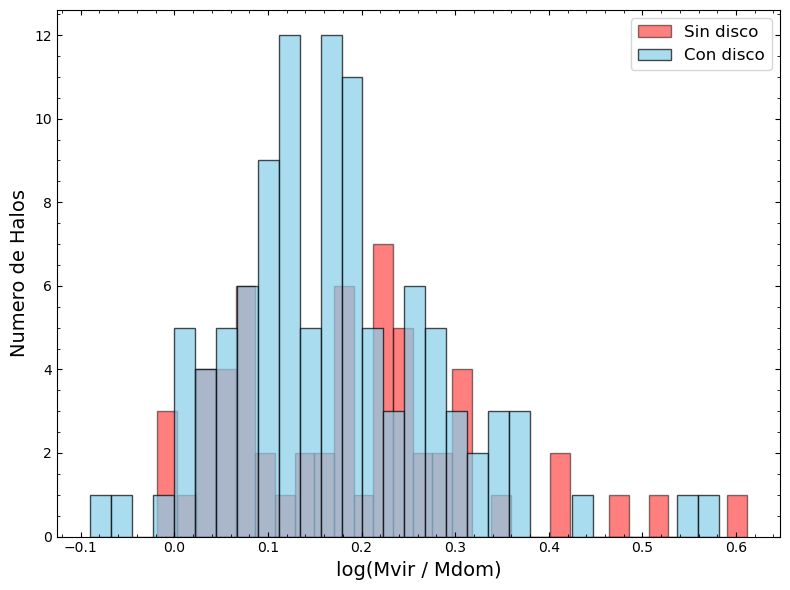

In [28]:
#histograma de Mvir/Mdom para halos con y sin disco
plt.figure(figsize=(8,6))
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='red', edgecolor='black', alpha=0.5, label='Sin disco')
#plt.hist(np.log10(z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']), bins=30, color='salmon', edgecolor='black', alpha=0.7, label='No disk')
plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Con disco')
#plt.hist(np.log10(z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']), bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='Disk')
plt.xlabel('log(Mvir / Mdom)', fontsize=14)
plt.ylabel('Numero de Halos', fontsize=14)
#plt.title('Distribución de Mvir / Mdom en halos con y sin disco', fontsize=16)
plt.legend(fontsize=12)
#mostrar los ticks secundarios entre los ticks principales
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.tight_layout()

plt.savefig(results_path + 'Mvir_Mdom_histogram_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:

# Extraer las distribuciones de Mvir_Mdom_ratio para halos con y sin disco
mvir_mdom_disk = z0_df[z0_df['has_disk'] == 1]['Mvir_Mdom_ratio']
mvir_mdom_nodisk = z0_df[z0_df['has_disk'] == 0]['Mvir_Mdom_ratio']

# Realizar el test de Kolmogorov-Smirnov
ks_stat, p_value = ks_2samp(mvir_mdom_disk, mvir_mdom_nodisk)

print(f"Test de Kolmogorov-Smirnov:")
print(f"Estadístico KS: {ks_stat:.4f}")
print(f"p-valor: {p_value:.4f}")
if p_value < 0.05:
    print("Conclusión: Las distribuciones son significativamente diferentes (p < 0.05)")
else:
    print("Conclusión: No hay evidencia suficiente de que las distribuciones sean diferentes (p ≥ 0.05)")

Test de Kolmogorov-Smirnov:
Estadístico KS: 0.1626
p-valor: 0.2429
Conclusión: No hay evidencia suficiente de que las distribuciones sean diferentes (p ≥ 0.05)


### Quitando outliers de la manera mas horrible posible

#### Halos con disco (naranja)

In [30]:
#quitar la de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el índice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el índice 12 con Mvir/Mvir0 = 1.1978295556684003e-05


In [31]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

In [32]:
#quitar la segunda de mas abajo
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 1)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con menor masa
min_Mvir = min(Mvirs)
min_index = Mvirs.index(min_Mvir)
min_halo = IDXS[min_index]
print(f"El halo con menor masa en z=4.01 es el índice {min_halo} con Mvir/Mvir0 = {min_Mvir}")

El halo con menor masa en z=4.01 es el índice 2 con Mvir/Mvir0 = 0.002681651319022898


In [33]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=min_halo).reset_index(drop=True)

#### Halos sin disco (azul)

In [34]:
#limpiar halos que no tienen disco outliers
#quitar la de mas arriba
Mvirs = []
IDXS = []
for i,row in history_accretion.iterrows():
    boolean_cond = (4.01 in row['z']) & (row['has_disk'] == 0)
    if boolean_cond:
        Mvirs.append(row['Mvir_ratio'][-1])
        IDXS.append(i)

#Encontrar el indice con mayor masa
max_Mvir = max(Mvirs)
max_index = Mvirs.index(max_Mvir)
max_halo = IDXS[max_index]
print(f"El halo con mayor masa en z=4.01 es el índice {max_halo} con Mvir/Mvir0 = {max_Mvir}")

El halo con mayor masa en z=4.01 es el índice 139 con Mvir/Mvir0 = 0.3177255198205521


In [35]:
#Eliminar el halo con menor masa en z=4.01
history_accretion = history_accretion.drop(index=max_halo).reset_index(drop=True)

In [36]:
history_accretion['Mdom/Mdom0'] = history_accretion.apply(lambda row: np.log10(row['Mdom']/row['Mdom'][row['z'] == 0]), axis=1)

In [37]:
# # Separar halos según si Mdom/Mdom0 aumenta o siempre disminuye
# halos_Mdomup = []
# halos_Mdomdown = []

# for i, row in history_accretion.iterrows():
#     # Calcular Mdom/Mdom0 para cada z
#     mdom_ratio = row['Mdom'] / row['Mdom'][row['z'] == 0]
    
#     # Verificar si algún valor es mayor a 1 (excluyendo z=0 que siempre es 1)
#     if np.any(mdom_ratio[1:] > 1):
#         halos_Mdomup.append(i)
#     else:
#         halos_Mdomdown.append(i)

# # Crear los DataFrames
# halos_Mdomup = history_accretion.loc[halos_Mdomup].reset_index(drop=True)
# halos_Mdomdown = history_accretion.loc[halos_Mdomdown].reset_index(drop=True)

# print(f"Halos con Mdom/Mdom0 > 1 en algún z: {len(halos_Mdomup)}")
# print(f"Halos con Mdom/Mdom0 ≤ 1 en algún z: {len(halos_Mdomdown)}")

## Tipos de evolución masa dominio

In [38]:
# Separar halos según la pendiente del ajuste de Mdom vs z
halos_Mdomup_idxs = []
halos_Mdomdown_idxs = []

def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

for i, row in history_accretion.iterrows():
    z_vals = np.array(row['z'])
    mdom_vals = np.array(row['Mdom'])
    
    # Normalizar por Mdom en z=0
    idx_0 = np.where(z_vals == 0)[0]
    if len(idx_0) > 0 and len(z_vals) >= 3:  # Necesitamos al menos 3 puntos para ajustar
        mdom_0 = mdom_vals[idx_0[0]]
        if mdom_0 > 0:
            mdom_ratio = mdom_vals / mdom_0
            log_mdom = np.log10(mdom_ratio)
            
            # Ajuste lineal: log(Mdom/Mdom0) = a*z + b
            try:
                popt, _ = curve_fit(linear_fit, z_vals, log_mdom)
                slope = popt[0]  # pendiente 'a'
                
                if slope > 0:
                    halos_Mdomup_idxs.append(i)
                else:
                    halos_Mdomdown_idxs.append(i)
            except:
                # Si el ajuste falla, no clasificar este halo
                pass

# Crear los DataFrames
halos_Mdomup = history_accretion.loc[halos_Mdomup_idxs].reset_index(drop=True)
halos_Mdomdown = history_accretion.loc[halos_Mdomdown_idxs].reset_index(drop=True)

print(f"Clasificación por pendiente de Mdom(z):")
print(f"Halos con pendiente positiva (Tipo 1 - acreción): {len(halos_Mdomup)}")
print(f"Halos con pendiente negativa (Tipo 2 - pérdida): {len(halos_Mdomdown)}")

Clasificación por pendiente de Mdom(z):
Halos con pendiente positiva (Tipo 1 - acreción): 32
Halos con pendiente negativa (Tipo 2 - pérdida): 128


### Mvir

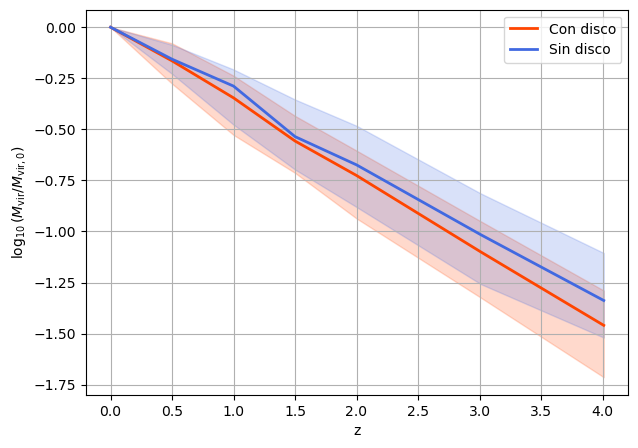

In [39]:
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar grupos con dispersión
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir']/row['Mvir'][row['z'] == 0])

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = sorted(mvir_by_z.keys())
    mvir_median = [np.median(mvir_by_z[zz]) for zz in z_vals]
    mvir_q25    = [np.percentile(mvir_by_z[zz], 25) for zz in z_vals]
    mvir_q75    = [np.percentile(mvir_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mvir_q25), np.log10(mvir_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm vir,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mdom

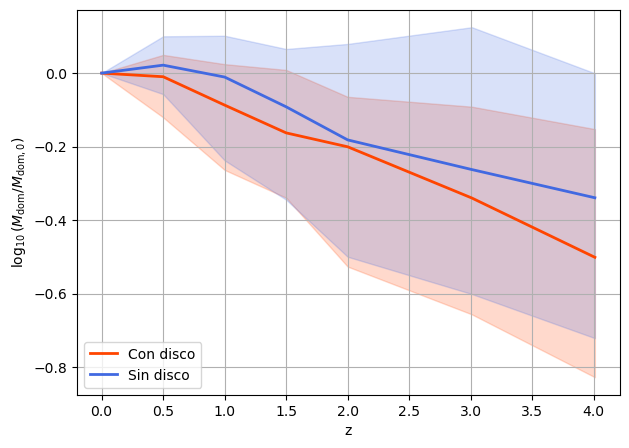

In [40]:
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom']/row['Mdom'][row['z'] == 0])

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = sorted(mdom_by_z.keys())
    mdom_median = [np.median(mdom_by_z[zz]) for zz in z_vals]
    mdom_q25    = [np.percentile(mdom_by_z[zz], 25) for zz in z_vals]
    mdom_q75    = [np.percentile(mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mdom_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mdom_q25), np.log10(mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z")
ax.set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
ax.legend()
ax.grid(True)
plt.show()


### Mvir/Mdom

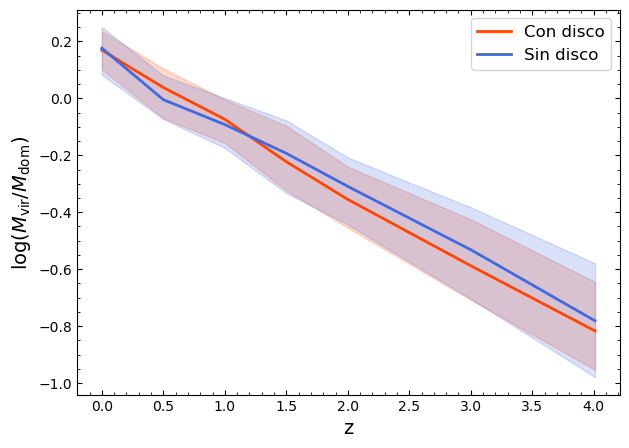

In [41]:
#mvir/mdom vs z con dispersión para halos con y sin disco
fig, ax = plt.subplots(figsize=(7,5))

# Función para graficar grupos con dispersión
def plot_group(halos, color, label):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = sorted(mvir_mdom_by_z.keys())
    mvir_mdom_median = [np.median(mvir_mdom_by_z[zz]) for zz in z_vals]
    mvir_mdom_q25    = [np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals]
    mvir_mdom_q75    = [np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals]

    # Mediana
    ax.plot(z_vals, np.log10(mvir_mdom_median), color=color, lw=2, label=label)
    # Banda de dispersión
    ax.fill_between(z_vals, np.log10(mvir_mdom_q25), np.log10(mvir_mdom_q75),
                    color=color, alpha=0.2)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(halos_disk, color='orangered', label='Con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(halos_nodisk, color='royalblue', label='Sin disco')

ax.set_xlabel("z", fontsize=14)
ax.set_ylabel(r"$\log(M_{\rm vir}/M_{\rm dom})$", fontsize=14)
#mostrar los ticks secundarios entre los ticks principales
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend(fontsize=12)
#ax.grid(True)
plt.savefig(results_path + 'Mvir_Mdom_vs_z_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()

## Mvir

In [42]:
def plot_group(ax, halos, color, title, outlier_indices=[]):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir = np.array(row['Mvir'])/row['Mvir'][row['z'] == 0]
        ax.plot(z, np.log10(mvir), color=color, alpha=0.1)
        if i in outlier_indices:
            ax.plot(z, np.log10(mvir), color='red', alpha=0.7)

    # Agrupar por z
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    mvir_q25    = np.array([np.percentile(mvir_by_z[zz], 25) for zz in z_vals])
    mvir_q75    = np.array([np.percentile(mvir_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_median),
                yerr=[np.log10(mvir_median)-np.log10(mvir_q25),
                      np.log10(mvir_q75)-np.log10(mvir_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ± IQR')

    #ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]


In [43]:
def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def plot_group_with_fit(ax, halos, color, color2, label, mass_type='Mvir'):
    """
    Función unificada para graficar halos con ajuste lineal.
    
    Parameters:
    -----------
    ax : matplotlib axis
        Eje donde se graficará
    halos : DataFrame
        DataFrame con los datos de los halos
    color : str
        Color para las líneas individuales y el ajuste
    color2 : str
        Color para los puntos de la mediana
    label : str
        Etiqueta para la leyenda
    mass_type : str, optional (default='Mvir')
        Tipo de masa a graficar: 'Mvir' o 'Mdom'
    """
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mass = np.array(row[mass_type]) / row[mass_type][row['z'] == 0]
        alpha_val = 0.2
        ax.plot(z, np.log10(mass), color=color, alpha=alpha_val)

    # Agrupar por z para obtener medianas
    mass_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row[mass_type]):
            if zz not in mass_by_z:
                mass_by_z[zz] = []
            mass_by_z[zz].append(m / row[mass_type][row['z'] == 0])

    z_vals = np.array(sorted(mass_by_z.keys()))
    mass_median = np.array([np.median(mass_by_z[zz]) for zz in z_vals])
    mass_q25 = np.array([np.percentile(mass_by_z[zz], 25) for zz in z_vals])
    mass_q75 = np.array([np.percentile(mass_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(
        z_vals, np.log10(mass_median),
        yerr=[
            np.log10(mass_median) - np.log10(mass_q25),
            np.log10(mass_q75) - np.log10(mass_median)
        ],
        fmt='o', color=color2, ecolor=color2, capsize=3,
        label=label + ' (datos)'
    )

    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mass_median))
    perr = np.sqrt(np.diag(pcov))

    a, b = popt
    da, db = perr

    # Errores relativos en %
    rel_da = 100 * da / abs(a) if a != 0 else np.nan
    rel_db = 100 * db / abs(b) if b != 0 else np.nan

    # Curva suave del ajuste
    z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
    fit_smooth = linear_fit(z_smooth, *popt)

    # Graficar ajuste
    ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2,
            label=f'{label} (ajuste)')

    ax.set_xlabel("z", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

    # Mostrar ecuación del ajuste con errores relativos
    print(f"{label}:")
    print(
        f"log({mass_type}/{mass_type}0) = "
        f"({a:.4f} ± {da:.4f}, rel {rel_da:.2f}%) * z + "
        f"({b:.4f} ± {db:.4f}, rel {rel_db:.2f}%)"
    )
    R2 = 1 - np.var(np.log10(mass_median) - linear_fit(z_vals, *popt)) / np.var(np.log10(mass_median))
    print(f"R² = {R2:.4f}")
    print()

In [44]:
# #ingles
# def linear_fit(z, a, b):
#     """Función lineal: y = a*z + b"""
#     return a*z + b

# def plot_group_with_fit(ax, halos, color, color2, label, mass_type='Mvir'):
#     """
#     Función unificada para graficar halos con ajuste lineal.
    
#     Parameters:
#     -----------
#     ax : matplotlib axis
#         Eje donde se graficará
#     halos : DataFrame
#         DataFrame con los datos de los halos
#     color : str
#         Color para las líneas individuales y el ajuste
#     color2 : str
#         Color para los puntos de la mediana
#     label : str
#         Etiqueta para la leyenda
#     mass_type : str, optional (default='Mvir')
#         Tipo de masa a graficar: 'Mvir' o 'Mdom'
#     """
#     # Historias individuales
#     for i, row in halos.iterrows():
#         z = np.array(row['z'])
#         mass = np.array(row[mass_type]) / row[mass_type][row['z'] == 0]
#         alpha_val = 0.2
#         ax.plot(z, np.log10(mass), color=color, alpha=alpha_val)

#     # Agrupar por z para obtener medianas
#     mass_by_z = {}
#     for i, row in halos.iterrows():
#         for zz, m in zip(row['z'], row[mass_type]):
#             if zz not in mass_by_z:
#                 mass_by_z[zz] = []
#             mass_by_z[zz].append(m / row[mass_type][row['z'] == 0])

#     z_vals = np.array(sorted(mass_by_z.keys()))
#     mass_median = np.array([np.median(mass_by_z[zz]) for zz in z_vals])
#     mass_q25 = np.array([np.percentile(mass_by_z[zz], 25) for zz in z_vals])
#     mass_q75 = np.array([np.percentile(mass_by_z[zz], 75) for zz in z_vals])

#     # Puntos de la mediana con barras de error
#     ax.errorbar(
#         z_vals, np.log10(mass_median),
#         yerr=[
#             np.log10(mass_median) - np.log10(mass_q25),
#             np.log10(mass_q75) - np.log10(mass_median)
#         ],
#         fmt='o', color=color2, ecolor=color2, capsize=3,
#         label=label + ' (data)'
#     )

#     # Ajuste lineal en escala logarítmica
#     popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mass_median))
#     perr = np.sqrt(np.diag(pcov))

#     a, b = popt
#     da, db = perr

#     # Errores relativos en %
#     rel_da = 100 * da / abs(a) if a != 0 else np.nan
#     rel_db = 100 * db / abs(b) if b != 0 else np.nan

#     # Curva suave del ajuste
#     z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
#     fit_smooth = linear_fit(z_smooth, *popt)

#     # Graficar ajuste
#     ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2,
#             label=f'{label} (fit)')

#     ax.set_xlabel("z", fontsize=14)
#     ax.grid(True)
#     ax.legend(fontsize=12)
#     ax.minorticks_on()
#     ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')

#     # Mostrar ecuación del ajuste con errores relativos
#     print(f"{label}:")
#     print(
#         f"log({mass_type}/{mass_type}0) = "
#         f"({a:.4f} ± {da:.4f}, rel {rel_da:.2f}%) * z + "
#         f"({b:.4f} ± {db:.4f}, rel {rel_db:.2f}%)"
#     )
#     R2 = 1 - np.var(np.log10(mass_median) - linear_fit(z_vals, *popt)) / np.var(np.log10(mass_median))
#     print(f"R² = {R2:.4f}")
#     print()

Con disco:
log(Mvir/Mvir0) = (-0.3670 ± 0.0031, rel 0.86%) * z + (0.0084 ± 0.0068, rel 81.22%)
R² = 0.9996

Sin disco:
log(Mvir/Mvir0) = (-0.3381 ± 0.0074, rel 2.20%) * z + (0.0080 ± 0.0161, rel 199.50%)
R² = 0.9976



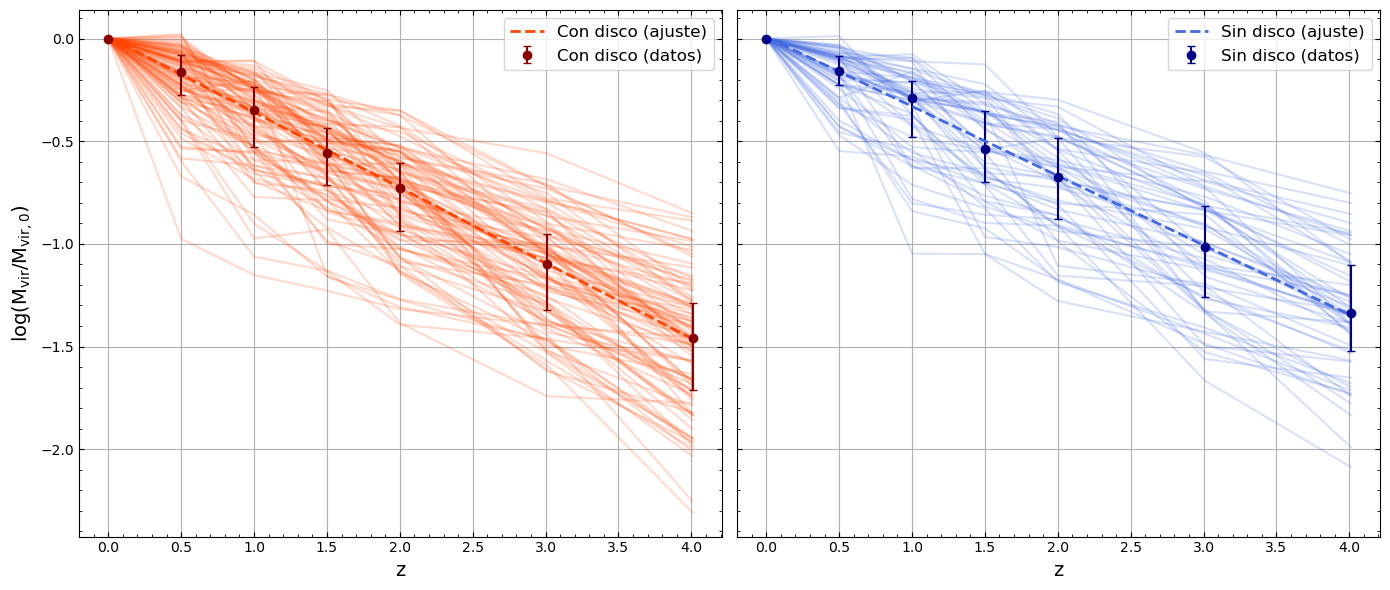

In [45]:
# Ajuste lineal a las curvas de Mvir/Mvir0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', color2='darkred', label='Con disco', mass_type='Mvir')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', color2='darkblue', label='Sin disco', mass_type='Mvir')

axs[0].set_ylabel(r"$\log(\rm{M}_{\rm vir}/\rm{M}_{\rm vir,0})$", fontsize=14)

plt.tight_layout()
plt.savefig(results_path + 'Mvir_Mvir0_fit_disk_nodisk_T2.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
# Extraer las pendientes de los ajustes lineales para cada grupo

def get_slopes_for_halos(halos):
    """Calcula la pendiente del ajuste lineal para cada halo"""
    slopes = []
    
    for i, row in halos.iterrows():
        z_vals = np.array(row['z'])
        mvir_ratio = np.array(row['Mvir']) / row['Mvir'][row['z'] == 0]
        log_mvir = np.log10(mvir_ratio)
        
        # Ajuste lineal individual
        try:
            popt, _ = curve_fit(linear_fit, z_vals, log_mvir)
            slopes.append(popt[0])  # pendiente
        except:
            continue
    
    return np.array(slopes)

# Obtener pendientes para cada grupo
slopes_disk = get_slopes_for_halos(halos_disk)
slopes_nodisk = get_slopes_for_halos(halos_nodisk)

print("=" * 80)
print("PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES")
print("=" * 80)
print(f"\nHalos con disco: n={len(slopes_disk)}")
print(f"  Media: {np.mean(slopes_disk):.4f}")
print(f"  Mediana: {np.median(slopes_disk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_disk):.4f}")

print(f"\nHalos sin disco: n={len(slopes_nodisk)}")
print(f"  Media: {np.mean(slopes_nodisk):.4f}")
print(f"  Mediana: {np.median(slopes_nodisk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_nodisk):.4f}")

# Test de normalidad (Shapiro-Wilk)
print("\n" + "-" * 80)
print("TEST DE NORMALIDAD (Shapiro-Wilk)")
_, p_disk = stats.shapiro(slopes_disk)
_, p_nodisk = stats.shapiro(slopes_nodisk)
print(f"Con disco: p-valor = {p_disk:.4f}")
print(f"Sin disco: p-valor = {p_nodisk:.4f}")

# Test de Mann-Whitney U (no paramétrico)
print("\n" + "-" * 80)
print("TEST DE MANN-WHITNEY U")
statistic_mw, pvalue_mw = stats.mannwhitneyu(slopes_disk, slopes_nodisk, alternative='two-sided')
print(f"Estadístico: {statistic_mw:.2f}")
print(f"P-valor: {pvalue_mw:.4f}")
if pvalue_mw < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")

# Test t de Student (paramétrico)
print("\n" + "-" * 80)
print("TEST T DE STUDENT (dos muestras)")
statistic_t, pvalue_t = stats.ttest_ind(slopes_disk, slopes_nodisk)
print(f"Estadístico t: {statistic_t:.4f}")
print(f"P-valor: {pvalue_t:.4f}")
if pvalue_t < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")


PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES

Halos con disco: n=103
  Media: -0.3698
  Mediana: -0.3598
  Desv. estándar: 0.0791

Halos sin disco: n=57
  Media: -0.3344
  Mediana: -0.3236
  Desv. estándar: 0.0778

--------------------------------------------------------------------------------
TEST DE NORMALIDAD (Shapiro-Wilk)
Con disco: p-valor = 0.3035
Sin disco: p-valor = 0.1959

--------------------------------------------------------------------------------
TEST DE MANN-WHITNEY U
Estadístico: 2199.00
P-valor: 0.0087
→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)

--------------------------------------------------------------------------------
TEST T DE STUDENT (dos muestras)
Estadístico t: -2.7117
P-valor: 0.0074
→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)


In [47]:
def fit_group(halos):
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log10(mvir_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

def test_param(param_name, val1, err1, val2, err2):
    """
    Prueba de hipótesis para comparar dos parámetros ajustados usando t-test.
    H0: val1 == val2
    H1: val1 != val2
    """
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    
    # Grados de libertad (aproximación de Welch-Satterthwaite)
    # Para errores de ajuste, usamos una aproximación conservadora
    df = ((err1**2 + err2**2)**2) / (err1**4 + err2**4)
    
    # p-valor bilateral usando distribución t
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    print(f"Prueba de hipótesis para {param_name}:")
    print(f"  {param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"  {param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"  Diferencia = {diff:.4f}")
    print(f"  Estadístico t = {t_stat:.3f}")
    print(f"  Grados de libertad ≈ {df:.1f}")
    print(f"  p-valor = {p_val:.4f}")
    
    if p_val < 0.05:
        print("  → Rechazamos H0: diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)")
    print()

# Uso
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Prueba de hipótesis para a:
  a_disk = -0.3670 ± 0.0031
  a_nodisk = -0.3381 ± 0.0074
  Diferencia = -0.0289
  Estadístico t = -3.579
  Grados de libertad ≈ 1.3
  p-valor = 0.1210
  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)



In [48]:
#fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mdom = np.array(row['Mdom'])/row['Mdom'][row['z'] == 0]
        ax.plot(z, np.log10(mdom), color=color, alpha=0.1)

    # Agrupar por z
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    mdom_q25    = np.array([np.percentile(mdom_by_z[zz], 25) for zz in z_vals])
    mdom_q75    = np.array([np.percentile(mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mdom_median),
                yerr=[np.log10(mdom_median)-np.log10(mdom_q25),
                      np.log10(mdom_q75)-np.log10(mdom_median)],
                fmt='o', color=color, ecolor='black', capsize=3,
                label='Mediana ± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

Mdom

Con disco:
log(Mdom/Mdom0) = (-0.1280 ± 0.0067, rel 5.25%) * z + (0.0338 ± 0.0145, rel 42.84%)
R² = 0.9864

Sin disco:
log(Mdom/Mdom0) = (-0.0973 ± 0.0098, rel 10.06%) * z + (0.0435 ± 0.0211, rel 48.52%)
R² = 0.9519



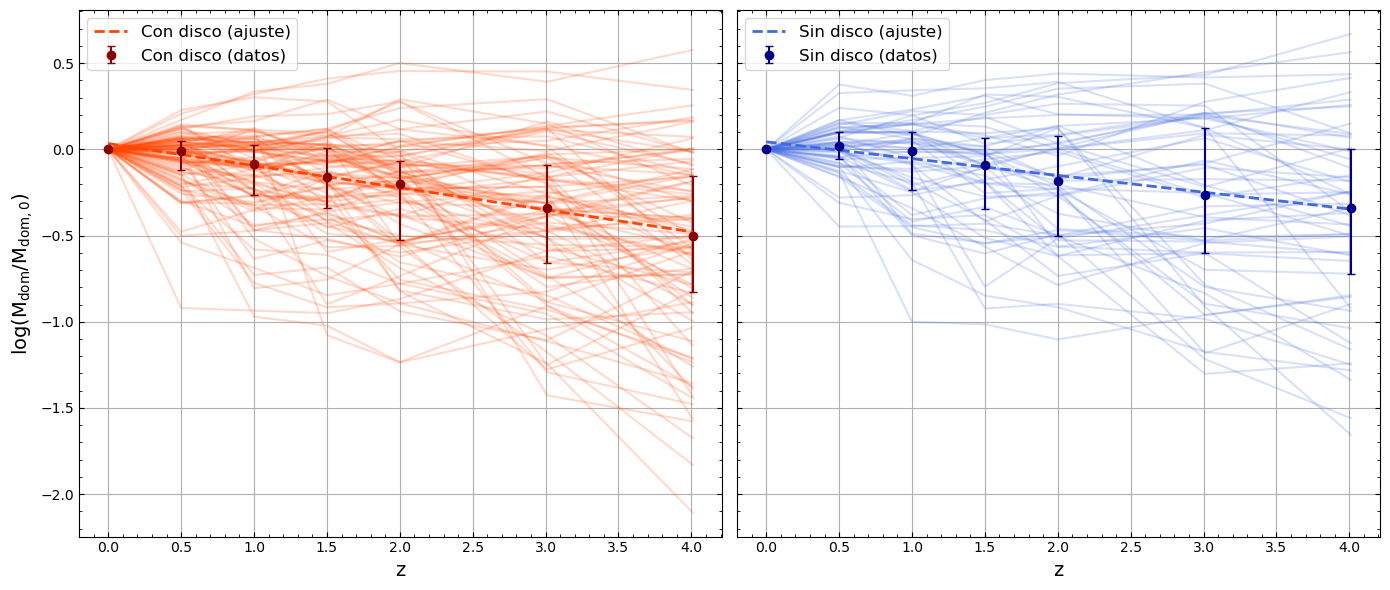

In [49]:
# Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logarítmica

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group_with_fit(axs[0], halos_disk, color='orangered', color2='darkred', label='Con disco', mass_type='Mdom')
#axs[0].set_title('Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', color2='darkblue', label='Sin disco', mass_type='Mdom')
#axs[1].set_title('Halos sin disco')
axs[0].set_ylabel(r"$\rm \log(M_{dom}/M_{dom,0})$", fontsize=14)
plt.tight_layout()
plt.savefig(results_path + 'Mdom_Mdom0_fit_disk_nodisk_T2.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# Extraer las pendientes de los ajustes lineales para cada grupo

def get_slopes_for_halos(halos):
    """Calcula la pendiente del ajuste lineal para cada halo"""
    slopes = []
    
    for i, row in halos.iterrows():
        z_vals = np.array(row['z'])
        mdom_ratio = np.array(row['Mdom']) / row['Mdom'][row['z'] == 0]
        log_mdom = np.log10(mdom_ratio)
        
        # Ajuste lineal individual
        try:
            popt, _ = curve_fit(linear_fit, z_vals, log_mdom)
            slopes.append(popt[0])  # pendiente
        except:
            continue
    
    return np.array(slopes)

# Obtener pendientes para cada grupo
slopes_disk = get_slopes_for_halos(halos_disk)
slopes_nodisk = get_slopes_for_halos(halos_nodisk)

print("=" * 80)
print("PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES")
print("=" * 80)
print(f"\nHalos con disco: n={len(slopes_disk)}")
print(f"  Media: {np.mean(slopes_disk):.4f}")
print(f"  Mediana: {np.median(slopes_disk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_disk):.4f}")

print(f"\nHalos sin disco: n={len(slopes_nodisk)}")
print(f"  Media: {np.mean(slopes_nodisk):.4f}")
print(f"  Mediana: {np.median(slopes_nodisk):.4f}")
print(f"  Desv. estándar: {np.std(slopes_nodisk):.4f}")

# Test de normalidad (Shapiro-Wilk)
print("\n" + "-" * 80)
print("TEST DE NORMALIDAD (Shapiro-Wilk)")
_, p_disk = stats.shapiro(slopes_disk)
_, p_nodisk = stats.shapiro(slopes_nodisk)
print(f"Con disco: p-valor = {p_disk:.4f}")
print(f"Sin disco: p-valor = {p_nodisk:.4f}")

# Test de Mann-Whitney U (no paramétrico)
print("\n" + "-" * 80)
print("TEST DE MANN-WHITNEY U")

statistic_mw, pvalue_mw = stats.mannwhitneyu(slopes_disk, slopes_nodisk, alternative='two-sided')
print(f"Estadístico: {statistic_mw:.2f}")
print(f"P-valor: {pvalue_mw:.4f}")
if pvalue_mw < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")

# Test t de Student (paramétrico)
print("\n" + "-" * 80)
print("TEST T DE STUDENT (dos muestras)")
statistic_t, pvalue_t = stats.ttest_ind(slopes_disk, slopes_nodisk)
print(f"Estadístico t: {statistic_t:.4f}")
print(f"P-valor: {pvalue_t:.4f}")
if pvalue_t < 0.05:
    print("→ Las pendientes son SIGNIFICATIVAMENTE DIFERENTES (p < 0.05)")
else:
    print("→ No hay diferencia significativa entre las pendientes")


PRUEBA DE HIPÓTESIS: COMPARACIÓN DE PENDIENTES

Halos con disco: n=103
  Media: -0.1362
  Mediana: -0.1196
  Desv. estándar: 0.1352

Halos sin disco: n=57
  Media: -0.1053
  Mediana: -0.0791
  Desv. estándar: 0.1414

--------------------------------------------------------------------------------
TEST DE NORMALIDAD (Shapiro-Wilk)
Con disco: p-valor = 0.0027
Sin disco: p-valor = 0.1152

--------------------------------------------------------------------------------
TEST DE MANN-WHITNEY U
Estadístico: 2543.00
P-valor: 0.1625
→ No hay diferencia significativa entre las pendientes

--------------------------------------------------------------------------------
TEST T DE STUDENT (dos muestras)
Estadístico t: -1.3543
P-valor: 0.1776
→ No hay diferencia significativa entre las pendientes


Pendientes calculadas: 103 (disco) vs 57 (sin disco)

Resultados Bootstrap (Método de pendientes individuales):
Pendiente media (Con disco): -0.1363 ± 0.0134
Pendiente media (Sin disco): -0.1052 ± 0.0187
Probabilidad (a_disk < a_nodisk): 0.9136


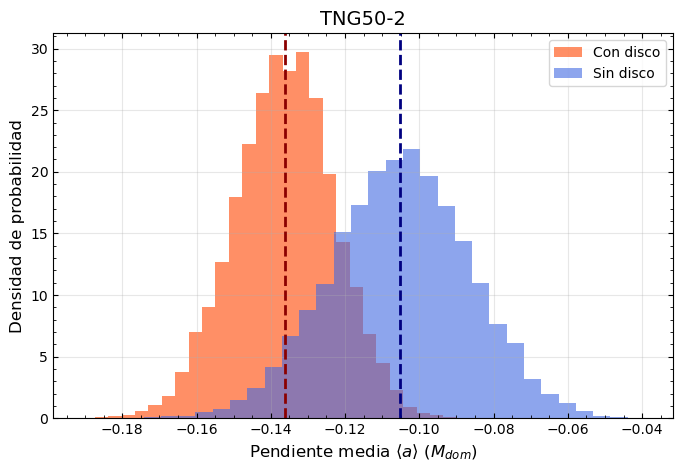

In [51]:
# Bootstrap robusto: Calculando pendientes individuales y luego bootstrapping de la media

# 1. Obtener la población de pendientes reales
pop_slopes_disk = get_slopes_for_halos(halos_disk)
pop_slopes_nodisk = get_slopes_for_halos(halos_nodisk)

print(f"Pendientes calculadas: {len(pop_slopes_disk)} (disco) vs {len(pop_slopes_nodisk)} (sin disco)")

# 2. Bootstrapping de la MEDIA de las pendientes
n_boot = 10000
boot_means_disk = []
boot_means_nodisk = []

np.random.seed(42)

for _ in range(n_boot):
    # Resamplear con reemplazo del conjunto de pendientes
    sample_disk = np.random.choice(pop_slopes_disk, size=len(pop_slopes_disk), replace=True)
    sample_nodisk = np.random.choice(pop_slopes_nodisk, size=len(pop_slopes_nodisk), replace=True)
    
    boot_means_disk.append(np.mean(sample_disk))
    boot_means_nodisk.append(np.mean(sample_nodisk))

boot_means_disk = np.array(boot_means_disk)
boot_means_nodisk = np.array(boot_means_nodisk)

# Probabilidad de que la pendiente media de disco sea menor (más negativa) que la de sin disco
prob_diff = np.mean(boot_means_disk < boot_means_nodisk)

print("\nResultados Bootstrap (Método de pendientes individuales):")
print(f"Pendiente media (Con disco): {np.mean(boot_means_disk):.4f} ± {np.std(boot_means_disk):.4f}")
print(f"Pendiente media (Sin disco): {np.mean(boot_means_nodisk):.4f} ± {np.std(boot_means_nodisk):.4f}")
print(f"Probabilidad (a_disk < a_nodisk): {prob_diff:.4f}")

# Graficar
plt.figure(figsize=(8, 5))
plt.hist(boot_means_disk, bins=30, alpha=0.6, color='orangered', density=True, label='Con disco')
plt.hist(boot_means_nodisk, bins=30, alpha=0.6, color='royalblue', density=True, label='Sin disco')
plt.axvline(np.mean(pop_slopes_disk), color='darkred', linestyle='--', lw=2)
plt.axvline(np.mean(pop_slopes_nodisk), color='navy', linestyle='--', lw=2)

plt.xlabel(r"Pendiente media $\langle a \rangle$ ($M_{dom}$)", fontsize=12)
plt.ylabel("Densidad de probabilidad", fontsize=12)
plt.title("TNG50-2", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.minorticks_on()
#mostrar los ticks de arriba y la derecha hacia adentro
plt.tick_params(axis='both', which='both', top=True, right=True, direction='in')
plt.savefig(results_path + 'Bootstrap_mean_slopes_Mdom_robust_T2.png', dpi=300, bbox_inches='tight')
plt.show()

Separando por aquellos con fracción de masa por encima de 0 en algun caso

Type 1:
log(Mvir/Mvir0) = (-0.2590 ± 0.0095, rel 3.66%) * z + (-0.0167 ± 0.0205, rel 122.83%)
R² = 0.9933

Type 2:
log(Mvir/Mvir0) = (-0.3801 ± 0.0064, rel 1.69%) * z + (0.0088 ± 0.0138, rel 156.71%)
R² = 0.9986

Type 1:
log(Mvir/Mvir0) = (-0.2415 ± 0.0084, rel 3.46%) * z + (-0.0113 ± 0.0181, rel 159.56%)
R² = 0.9940

Type 2:
log(Mvir/Mvir0) = (-0.3606 ± 0.0151, rel 4.20%) * z + (0.0013 ± 0.0327, rel 2485.25%)
R² = 0.9913



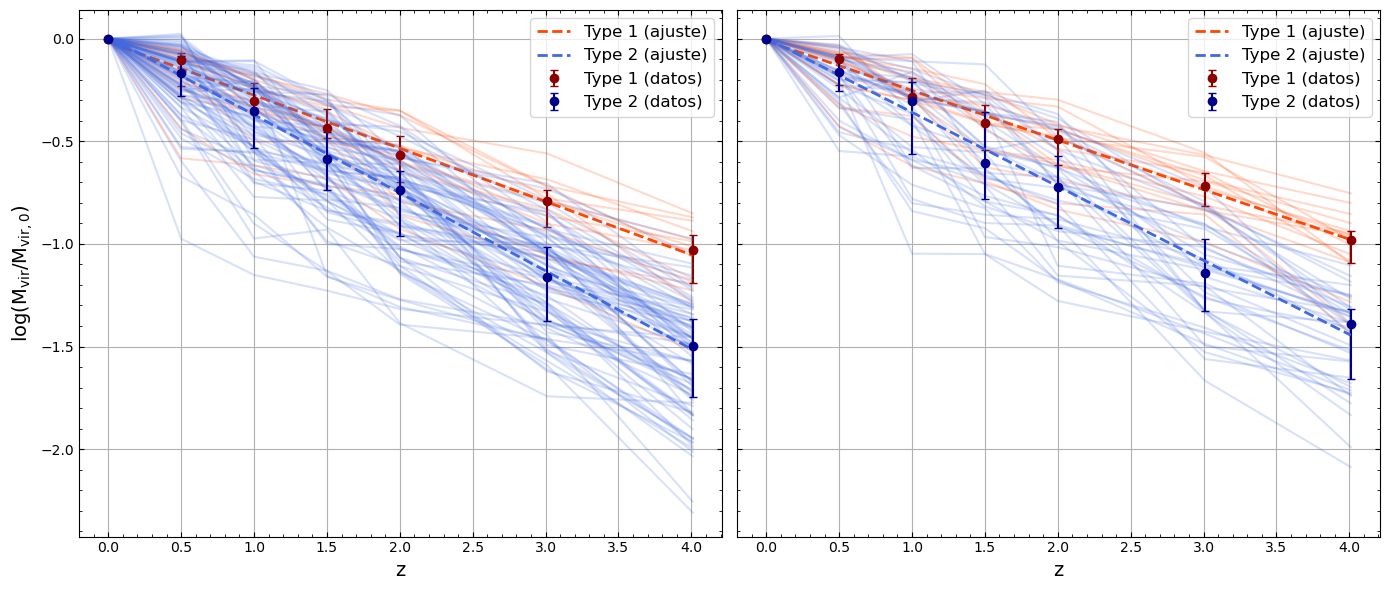

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_group_with_fit(axs[0], halos_Mdomup[halos_Mdomup['has_disk'] == 1], color='orangered', color2='darkred', label='Type 1', mass_type='Mvir')
plot_group_with_fit(axs[0], halos_Mdomdown[halos_Mdomdown['has_disk'] == 1], color='royalblue', color2='darkblue', label='Type 2', mass_type='Mvir')
#axs[0].set_title('Halos con disco')

plot_group_with_fit(axs[1], halos_Mdomup[halos_Mdomup['has_disk'] == 0], color='orangered', color2='darkred', label='Type 1', mass_type='Mvir')
plot_group_with_fit(axs[1], halos_Mdomdown[halos_Mdomdown['has_disk'] == 0], color='royalblue', color2='darkblue', label='Type 2', mass_type='Mvir')
#axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log(\rm M_{vir}/M_{vir,0})$", fontsize=14)
plt.tight_layout()
plt.savefig(results_path + 'Mvir_Mvir0_fit_accretion_types_disk_nodisk_T2.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# Realizar pruebas de hipótesis para comparar las curvas Type 1 vs Type 2 
# tanto para halos con disco como sin disco


def linear_fit(z, a, b):
    """Función lineal: y = a*z + b"""
    return a*z + b

def fit_group_parameters(halos):
    """Ajusta la curva lineal y devuelve parámetros con errores"""
    # Agrupar por z para obtener medianas
    mvir_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']):
            if zz not in mvir_by_z:
                mvir_by_z[zz] = []
            mvir_by_z[zz].append(m/row['Mvir'][row['z'] == 0])

    z_vals = np.array(sorted(mvir_by_z.keys()))
    mvir_median = np.array([np.median(mvir_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mvir_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return popt, perr

def test_parameters(group1, group2, label1, label2):
    """Realiza test de hipótesis para comparar parámetros entre dos grupos"""
    popt1, perr1 = fit_group_parameters(group1)
    popt2, perr2 = fit_group_parameters(group2)
    
    print(f"\n=== Comparación {label1} vs {label2} ===")
    
    # Test para parámetro 'a' (pendiente)
    diff_a = popt1[0] - popt2[0]
    se_a = np.sqrt(perr1[0]**2 + perr2[0]**2)
    t_stat_a = diff_a / se_a
    p_val_a = 2*(1 - stats.norm.cdf(abs(t_stat_a)))
    
    print(f"Parámetro a (pendiente):")
    print(f"  {label1}: {popt1[0]:.4f} ± {perr1[0]:.4f}")
    print(f"  {label2}: {popt2[0]:.4f} ± {perr2[0]:.4f}")
    print(f"  Diferencia: {diff_a:.4f}")
    print(f"  t-statistic: {t_stat_a:.3f}")
    print(f"  p-value: {p_val_a:.4f}")
    
    if p_val_a < 0.05:
        print("  → Diferencia SIGNIFICATIVA en pendiente")
    else:
        print("  → No hay diferencia significativa en pendiente")
    
    # Test para parámetro 'b' (intercepto)
    diff_b = popt1[1] - popt2[1]
    se_b = np.sqrt(perr1[1]**2 + perr2[1]**2)
    t_stat_b = diff_b / se_b
    p_val_b = 2*(1 - stats.norm.cdf(abs(t_stat_b)))
    
    print(f"\nParámetro b (intercepto):")
    print(f"  {label1}: {popt1[1]:.4f} ± {perr1[1]:.4f}")
    print(f"  {label2}: {popt2[1]:.4f} ± {perr2[1]:.4f}")
    print(f"  Diferencia: {diff_b:.4f}")
    print(f"  t-statistic: {t_stat_b:.3f}")
    print(f"  p-value: {p_val_b:.4f}")
    
    if p_val_b < 0.05:
        print("  → Diferencia SIGNIFICATIVA en intercepto")
    else:
        print("  → No hay diferencia significativa en intercepto")

# Separar grupos según Mdom evolution y presencia de disco
type1_with_disk = halos_Mdomup[halos_Mdomup['has_disk'] == 1]
type2_with_disk = halos_Mdomdown[halos_Mdomdown['has_disk'] == 1]
type1_without_disk = halos_Mdomup[halos_Mdomup['has_disk'] == 0]
type2_without_disk = halos_Mdomdown[halos_Mdomdown['has_disk'] == 0]

print("PRUEBAS DE HIPÓTESIS PARA CURVAS MVIR/MVIR0 vs z")
print("=" * 60)

# Test para halos CON disco: Type 1 vs Type 2
test_parameters(type1_with_disk, type2_with_disk, 
               "Type 1 (con disco)", "Type 2 (con disco)")

# Test para halos SIN disco: Type 1 vs Type 2  
test_parameters(type1_without_disk, type2_without_disk,
               "Type 1 (sin disco)", "Type 2 (sin disco)")

print(f"\nTamaños de muestra:")
print(f"Type 1 con disco: {len(type1_with_disk)} halos")
print(f"Type 2 con disco: {len(type2_with_disk)} halos")
print(f"Type 1 sin disco: {len(type1_without_disk)} halos")
print(f"Type 2 sin disco: {len(type2_without_disk)} halos")
### Mdom

PRUEBAS DE HIPÓTESIS PARA CURVAS MVIR/MVIR0 vs z

=== Comparación Type 1 (con disco) vs Type 2 (con disco) ===
Parámetro a (pendiente):
  Type 1 (con disco): -0.2590 ± 0.0095
  Type 2 (con disco): -0.3801 ± 0.0064
  Diferencia: 0.1211
  t-statistic: 10.573
  p-value: 0.0000
  → Diferencia SIGNIFICATIVA en pendiente

Parámetro b (intercepto):
  Type 1 (con disco): -0.0167 ± 0.0205
  Type 2 (con disco): 0.0088 ± 0.0138
  Diferencia: -0.0255
  t-statistic: -1.032
  p-value: 0.3021
  → No hay diferencia significativa en intercepto

=== Comparación Type 1 (sin disco) vs Type 2 (sin disco) ===
Parámetro a (pendiente):
  Type 1 (sin disco): -0.2415 ± 0.0084
  Type 2 (sin disco): -0.3606 ± 0.0151
  Diferencia: 0.1191
  t-statistic: 6.883
  p-value: 0.0000
  → Diferencia SIGNIFICATIVA en pendiente

Parámetro b (intercepto):
  Type 1 (sin disco): -0.0113 ± 0.0181
  Type 2 (sin disco): 0.0013 ± 0.0327
  Diferencia: -0.0126
  t-statistic: -0.338
  p-value: 0.7352
  → No hay diferencia significativ

COMPARACIÓN: Halos CON DISCO
Tipo 1 (Mdom crece): n=15, media=-0.2651, mediana=-0.2650, std=0.0342
Tipo 2 (Mdom decrece): n=88, media=-0.3877, mediana=-0.3768, std=0.0703
----------------------------------------
Test Mann-Whitney U: p-valor = 1.28e-08
Test t-Student (Welch): p-valor = 1.95e-12
>>> CONCLUSIÓN: Las distribuciones de pendientes son SIGNIFICATIVAMENTE DIFERENTES.


COMPARACIÓN: Halos SIN DISCO
Tipo 1 (Mdom crece): n=17, media=-0.2489, mediana=-0.2467, std=0.0311
Tipo 2 (Mdom decrece): n=40, media=-0.3708, mediana=-0.3453, std=0.0615
----------------------------------------
Test Mann-Whitney U: p-valor = 8.17e-09
Test t-Student (Welch): p-valor = 2.42e-13
>>> CONCLUSIÓN: Las distribuciones de pendientes son SIGNIFICATIVAMENTE DIFERENTES.




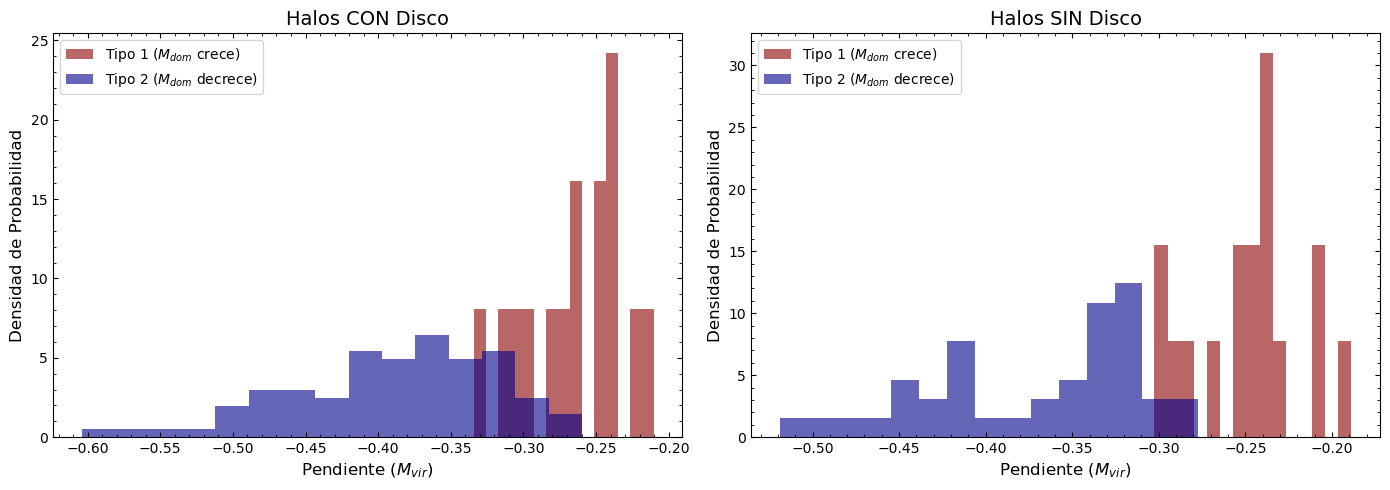

In [54]:

def get_individual_slopes(halos):
    """
    Calcula la pendiente 'a' del ajuste lineal log(Mvir/Mvir0) = a*z + b
    para cada halo individualmente.
    """
    slopes = []
    for i, row in halos.iterrows():
        z_vals = np.array(row['z'])
        # Evitar divisiones por cero o logs inválidos si los hay
        if row['Mvir'][row['z'] == 0] == 0: continue
        
        mvir_ratio = np.array(row['Mvir']) / row['Mvir'][row['z'] == 0]
        
        # Filtrar valores <= 0 para el log
        valid_mask = mvir_ratio > 0
        if np.sum(valid_mask) < 3: continue # Necesitamos al menos unos puntos para ajustar
        
        log_mvir = np.log10(mvir_ratio[valid_mask])
        z_valid = z_vals[valid_mask]
        
        try:
            # Ajuste lineal: y = a*x + b
            # polyfit grado 1 devuelve [pendiente, intercepto]
            p = np.polyfit(z_valid, log_mvir, 1)
            slopes.append(p[0])
        except:
            continue
            
    return np.array(slopes)

# 1. Obtener pendientes individuales para cada subgrupo
slopes_t1_disk = get_individual_slopes(type1_with_disk)
slopes_t2_disk = get_individual_slopes(type2_with_disk)

slopes_t1_nodisk = get_individual_slopes(type1_without_disk)
slopes_t2_nodisk = get_individual_slopes(type2_without_disk)

def report_comparison(group1, group2, label1, label2, title):
    print("="*80)
    print(f"COMPARACIÓN: {title}")
    print("="*80)
    
    # Estadísticas básicas
    print(f"{label1}: n={len(group1)}, media={np.mean(group1):.4f}, mediana={np.median(group1):.4f}, std={np.std(group1):.4f}")
    print(f"{label2}: n={len(group2)}, media={np.mean(group2):.4f}, mediana={np.median(group2):.4f}, std={np.std(group2):.4f}")
    
    # Test de Mann-Whitney U (No paramétrico, robusto a outliers y no normalidad)
    stat_u, p_u = mannwhitneyu(group1, group2)
    
    # Test T de Student (Paramétrico, asume normalidad/n grande)
    stat_t, p_t = ttest_ind(group1, group2, equal_var=False)
    
    print("-" * 40)
    print(f"Test Mann-Whitney U: p-valor = {p_u:.2e}")
    print(f"Test t-Student (Welch): p-valor = {p_t:.2e}")
    
    if p_u < 0.05:
        print(">>> CONCLUSIÓN: Las distribuciones de pendientes son SIGNIFICATIVAMENTE DIFERENTES.")
    else:
        print(">>> CONCLUSIÓN: No hay evidencia suficiente para distinguir las pendientes.")
    print("\n")

# 2. Ejecutar comparaciones
report_comparison(slopes_t1_disk, slopes_t2_disk, 
                 "Tipo 1 (Mdom crece)", "Tipo 2 (Mdom decrece)", 
                 "Halos CON DISCO")

report_comparison(slopes_t1_nodisk, slopes_t2_nodisk, 
                 "Tipo 1 (Mdom crece)", "Tipo 2 (Mdom decrece)", 
                 "Halos SIN DISCO")

# 3. Visualización
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histograma Con Disco
axs[0].hist(slopes_t1_disk, bins=15, alpha=0.6, density=True, color='darkred', label='Tipo 1 ($M_{dom}$ crece)')
axs[0].hist(slopes_t2_disk, bins=15, alpha=0.6, density=True, color='darkblue', label='Tipo 2 ($M_{dom}$ decrece)')
axs[0].set_title('Halos CON Disco', fontsize=14)
axs[0].set_xlabel(r'Pendiente ($M_{vir}$)', fontsize=12)
axs[0].set_ylabel('Densidad de Probabilidad', fontsize=12)

axs[0].legend()

# Histograma Sin Disco
axs[1].hist(slopes_t1_nodisk, bins=15, alpha=0.6, density=True, color='darkred', label='Tipo 1 ($M_{dom}$ crece)')
axs[1].hist(slopes_t2_nodisk, bins=15, alpha=0.6, density=True, color='darkblue', label='Tipo 2 ($M_{dom}$ decrece)')
axs[1].set_title('Halos SIN Disco', fontsize=14)
axs[1].set_xlabel(r'Pendiente ($M_{vir}$)', fontsize=12)
axs[1].set_ylabel('Densidad de Probabilidad', fontsize=12)
axs[1].legend()

axs[0].minorticks_on()
axs[0].tick_params(axis='both', which='both', top=True, right=True, direction='in')

axs[1].minorticks_on()
axs[1].tick_params(axis='both', which='both', top=True, right=True, direction='in')

plt.tight_layout()

#guardar la figura
plt.savefig(results_path + 'Pendiente_distribuciones_accretion_types_disk_nodisk_T2.png', dpi=300, bbox_inches='tight')
plt.show()

Tipo 1:
log(Mdom/Mdom0) = (0.0262 ± 0.0109, rel 41.63%) * z + (-0.0199 ± 0.0236, rel 118.11%)
R² = 0.5357

Tipo 2:
log(Mdom/Mdom0) = (-0.1460 ± 0.0078, rel 5.36%) * z + (0.0387 ± 0.0169, rel 43.67%)
R² = 0.9858

Tipo 1:
log(Mdom/Mdom0) = (0.0356 ± 0.0143, rel 40.13%) * z + (0.0292 ± 0.0308, rel 105.38%)
R² = 0.5540

Tipo 2:
log(Mdom/Mdom0) = (-0.1498 ± 0.0175, rel 11.68%) * z + (0.0330 ± 0.0378, rel 114.56%)
R² = 0.9362



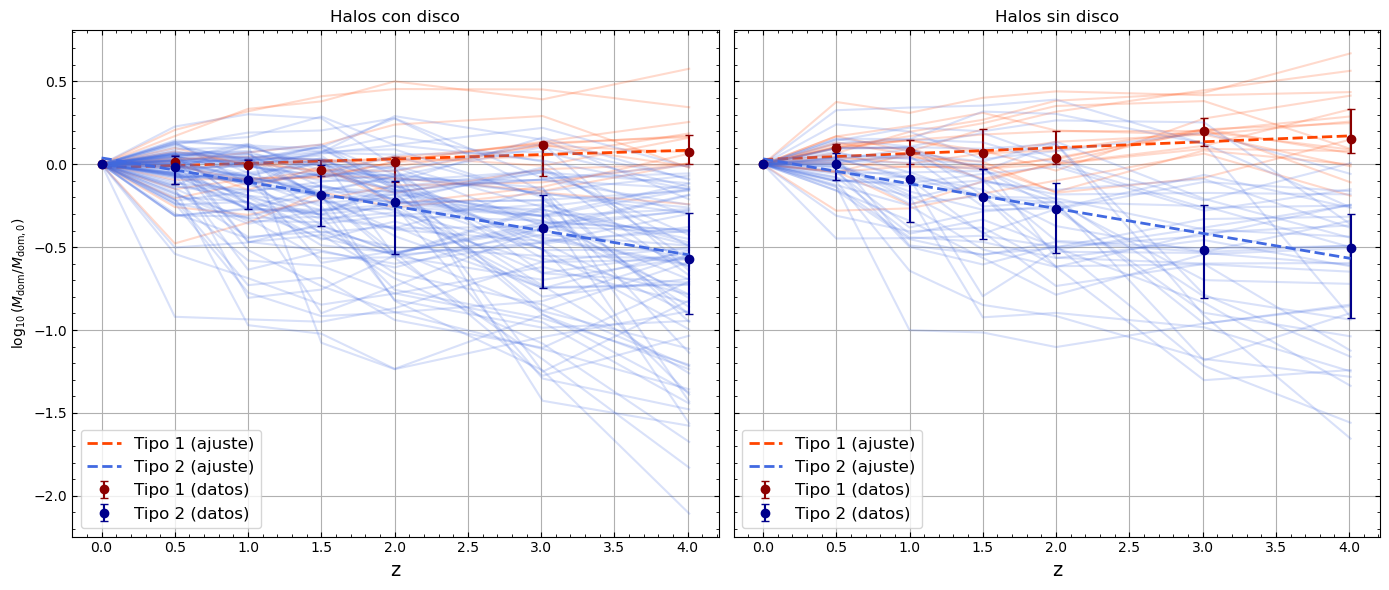

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_group_with_fit(axs[0], halos_Mdomup[halos_Mdomup['has_disk'] == 1], color='orangered', color2='darkred', label='Tipo 1', mass_type='Mdom')
plot_group_with_fit(axs[0], halos_Mdomdown[halos_Mdomdown['has_disk'] == 1], color='royalblue', color2='darkblue', label='Tipo 2', mass_type='Mdom')
axs[0].set_title('Halos con disco')

plot_group_with_fit(axs[1], halos_Mdomup[halos_Mdomup['has_disk'] == 0], color='orangered', color2='darkred', label='Tipo 1', mass_type='Mdom')
plot_group_with_fit(axs[1], halos_Mdomdown[halos_Mdomdown['has_disk'] == 0], color='royalblue', color2='darkblue', label='Tipo 2', mass_type='Mdom')
axs[1].set_title('Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm dom}/M_{\rm dom,0})$")
plt.tight_layout()
plt.show()

$M_{dom}(z)/M_{dom}(0) = a*z + b*ln(1+z)$ 

In [56]:
# # Ajuste lineal a las curvas de Mdom/Mdom0 vs z en escala logarítmica

# fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# def other_fit(z, a, b):
#     """Función: y = b*ln(1+z) + a*z"""
#     return b*np.log(1+z) + a*z

# def plot_group_with_fit(ax, halos, color, label):
#     # Agrupar por z para obtener medianas
#     mdom_by_z = {}
#     for i, row in halos.iterrows():
#         for zz, m in zip(row['z'], row['Mdom']):
#             if zz not in mdom_by_z:
#                 mdom_by_z[zz] = []
#             mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

#     z_vals = np.array(sorted(mdom_by_z.keys()))
#     mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
#     # Ajuste lineal en escala logarítmica
#     popt, pcov = curve_fit(other_fit, z_vals, np.log(mdom_median))
    
#     # Crear curva suave para el ajuste
#     z_smooth = np.linspace(z_vals.min(), z_vals.max(), 200)
#     fit_smooth = other_fit(z_smooth, *popt)
    
#     # Graficar datos originales
#     ax.plot(z_vals, np.log(mdom_median), 'o', color='k', label=f'{label} (datos)')
    
#     # Graficar ajuste
#     ax.plot(z_smooth, fit_smooth, '--', color=color, linewidth=2, 
#             label=f'{label} (ajuste)')
    
#     ax.set_xlabel("z")
#     ax.grid(True)
#     ax.legend()
    
#     # Mostrar ecuación del ajuste
#     print(f"{label}:")
#     print(f"ln(Mdom/Mdom0) = {popt[0]:.4f}*z + {popt[1]:.4f}*ln(1+z)")
#     print(f"R² = {1 - np.var(np.log(mdom_median) - other_fit(z_vals, *popt))/np.var(np.log(mdom_median)):.4f}")
#     print()

# # Halos con disco
# halos_disk = history_accretion[history_accretion['has_disk'] == 1]
# plot_group_with_fit(axs[0], halos_disk, color='orangered', label='Con disco')
# axs[0].set_title('Halos con disco')

# # Halos sin disco
# halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
# plot_group_with_fit(axs[1], halos_nodisk, color='royalblue', label='Sin disco')
# axs[1].set_title('Halos sin disco')

# axs[0].set_ylabel(r"$\ln(M_{\rm dom}/M_{\rm dom,0})$")
# plt.tight_layout()
# plt.show()

Mdom con fit lineal


In [57]:
def fit_group(halos):
    # Agrupar por z para obtener medianas
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m/row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    
    # Ajuste lineal en escala logarítmica
    popt, pcov = curve_fit(linear_fit, z_vals, np.log10(mdom_median))
    perr = np.sqrt(np.diag(pcov))  # errores estándar
    
    return z_vals, np.log10(mdom_median), popt, perr

# Ajustar ambos grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

z_disk, y_disk, popt_disk, perr_disk = fit_group(halos_disk)
z_nodisk, y_nodisk, popt_nodisk, perr_nodisk = fit_group(halos_nodisk)

def test_param(param_name, val1, err1, val2, err2):
    """
    Prueba de hipótesis para comparar dos parámetros ajustados usando t-test.
    H0: val1 == val2
    H1: val1 != val2
    """
    diff = val1 - val2
    se = np.sqrt(err1**2 + err2**2)
    t_stat = diff / se
    
    # Grados de libertad (aproximación de Welch-Satterthwaite)
    # Para errores de ajuste, usamos una aproximación conservadora
    df = ((err1**2 + err2**2)**2) / (err1**4 + err2**4)
    
    # p-valor bilateral usando distribución t
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    print(f"Prueba de hipótesis para {param_name}:")
    print(f"  {param_name}_disk = {val1:.4f} ± {err1:.4f}")
    print(f"  {param_name}_nodisk = {val2:.4f} ± {err2:.4f}")
    print(f"  Diferencia = {diff:.4f}")
    print(f"  Estadístico t = {t_stat:.3f}")
    print(f"  Grados de libertad ≈ {df:.1f}")
    print(f"  p-valor = {p_val:.4f}")
    
    if p_val < 0.05:
        print("  → Rechazamos H0: diferencia estadísticamente significativa (p < 0.05)")
    else:
        print("  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)")
    print()

# Uso
test_param("a", popt_disk[0], perr_disk[0], popt_nodisk[0], perr_nodisk[0])

Prueba de hipótesis para a:
  a_disk = -0.1280 ± 0.0067
  a_nodisk = -0.0973 ± 0.0098
  Diferencia = -0.0307
  Estadístico t = -2.588
  Grados de libertad ≈ 1.8
  p-valor = 0.1382
  → No rechazamos H0: no hay evidencia suficiente de diferencia (p ≥ 0.05)



Mvir

### Bootstrapping

In [58]:
def fit_group(halos):
    """Hace el ajuste a la mediana y devuelve parámetros (a, b)."""
    mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mdom']):
            if zz not in mdom_by_z:
                mdom_by_z[zz] = []
            mdom_by_z[zz].append(m / row['Mdom'][row['z'] == 0])

    z_vals = np.array(sorted(mdom_by_z.keys()))
    mdom_median = np.array([np.median(mdom_by_z[zz]) for zz in z_vals])
    # ajuste a la curva
    popt, _ = curve_fit(linear_fit, z_vals, np.log(mdom_median))
    return popt  # (a, b)

# Bootstrap
def bootstrap_params(halos, n_boot=500, seed=0):
    rng = np.random.default_rng(seed)
    a_vals, b_vals = [], []
    n = len(halos)
    for _ in range(n_boot):
        sample = halos.sample(n, replace=True, random_state=rng)
        try:
            a, b = fit_group(sample)
            a_vals.append(a)
            b_vals.append(b)
        except:
            continue
    return np.array(a_vals), np.array(b_vals)

# Separar grupos
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]

# Ejecutar bootstrap
a_disk, b_disk = bootstrap_params(halos_disk, n_boot=1000)
a_nodisk, b_nodisk = bootstrap_params(halos_nodisk, n_boot=1000)

# Comparación
diff_a = a_disk - a_nodisk[:, None]  # todas las diferencias posibles
p_value = (np.sum(diff_a < 0) / diff_a.size)  # probabilidad de que a_disk < a_nodisk

print(f"Media bootstrap a_disk = {np.mean(a_disk):.4f} ± {np.std(a_disk):.4f}")
print(f"Media bootstrap a_nodisk = {np.mean(a_nodisk):.4f} ± {np.std(a_nodisk):.4f}")
print(f"Probabilidad a_disk < a_nodisk = {p_value:.3f}")

Media bootstrap a_disk = -0.2945 ± 0.0299
Media bootstrap a_nodisk = -0.2240 ± 0.0559
Probabilidad a_disk < a_nodisk = 0.863


El análisis bootstrap sugiere que los halos con disco presentan una pendiente más negativa en su historia de acreción (a=−0.41) que los halos sin disco (a=−0.23), con una probabilidad del 89.5% de que esta diferencia sea real. Esto indica que, aunque la señal no alcanza el umbral clásico de significancia estadística, existe evidencia moderada de que la formación temprana de masa está asociada a la presencia de discos en las galaxias.

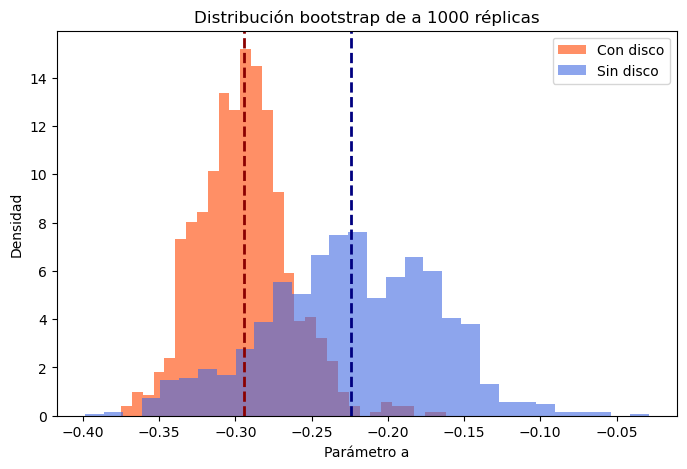

In [59]:
# Distribuciones de a
plt.figure(figsize=(8,5))
plt.hist(a_disk, bins=30, alpha=0.6, color="orangered", density=True, label="Con disco")
plt.hist(a_nodisk, bins=30, alpha=0.6, color="royalblue", density=True, label="Sin disco")
plt.axvline(np.mean(a_disk), color="darkred", linestyle="--", lw=2)
plt.axvline(np.mean(a_nodisk), color="navy", linestyle="--", lw=2)
plt.xlabel("Parámetro a")
plt.ylabel("Densidad")
plt.legend()
plt.title("Distribución bootstrap de a 1000 réplicas")
plt.savefig(results_path + 'bootstrap_a_disk_nodisk_T3.png', dpi=300, bbox_inches='tight')
plt.show()             

### Mvir/Mdom

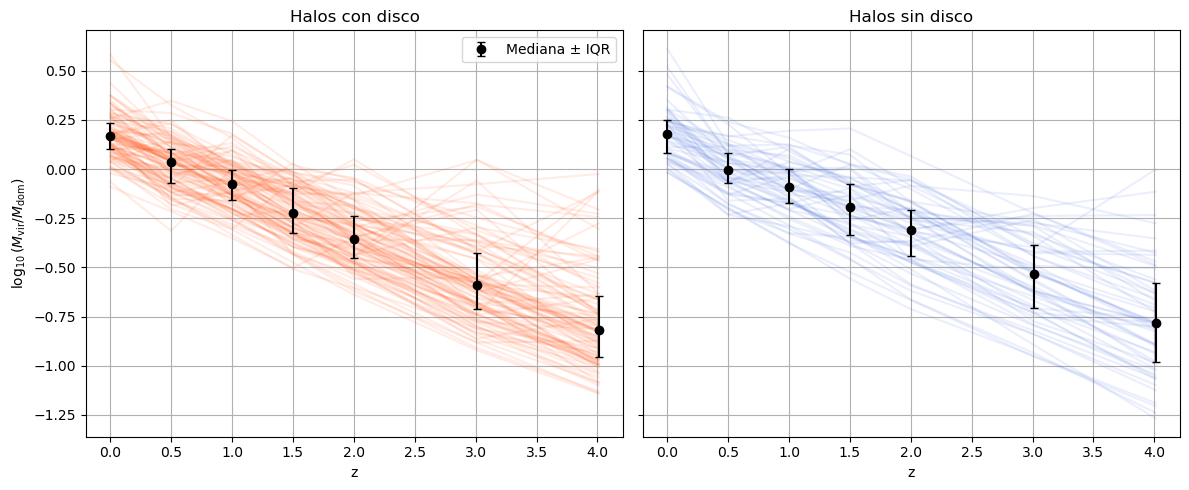

In [60]:
#mvir/mdom vs z con dispersión para halos con y sin disco

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

def plot_group(ax, halos, color, title):
    # Historias individuales
    for i, row in halos.iterrows():
        z = np.array(row['z'])
        mvir_mdom = np.array(row['Mvir']/row['Mdom'])
        ax.plot(z, np.log10(mvir_mdom), color=color, alpha=0.1)

    # Agrupar por z
    mvir_mdom_by_z = {}
    for i, row in halos.iterrows():
        for zz, m in zip(row['z'], row['Mvir']/row['Mdom']):
            if zz not in mvir_mdom_by_z:
                mvir_mdom_by_z[zz] = []
            mvir_mdom_by_z[zz].append(m)

    z_vals = np.array(sorted(mvir_mdom_by_z.keys()))
    mvir_mdom_median = np.array([np.median(mvir_mdom_by_z[zz]) for zz in z_vals])
    mvir_mdom_q25    = np.array([np.percentile(mvir_mdom_by_z[zz], 25) for zz in z_vals])
    mvir_mdom_q75    = np.array([np.percentile(mvir_mdom_by_z[zz], 75) for zz in z_vals])

    # Puntos de la mediana con barras de error
    ax.errorbar(z_vals, np.log10(mvir_mdom_median),
                yerr=[np.log10(mvir_mdom_median)-np.log10(mvir_mdom_q25),
                      np.log10(mvir_mdom_q75)-np.log10(mvir_mdom_median)],
                fmt='o', color='black', ecolor='black', capsize=3,
                label='Mediana ± IQR')

    ax.set_title(title)
    ax.set_xlabel("z")
    ax.grid(True)

# Halos con disco
halos_disk = history_accretion[history_accretion['has_disk'] == 1]
plot_group(axs[0], halos_disk, color='orangered', title='Halos con disco')

# Halos sin disco
halos_nodisk = history_accretion[history_accretion['has_disk'] == 0]
plot_group(axs[1], halos_nodisk, color='royalblue', title='Halos sin disco')

axs[0].set_ylabel(r"$\log_{10}(M_{\rm vir}/M_{\rm dom})$")
axs[0].legend()

plt.tight_layout()
plt.show()

# Tests estadisticos

In [61]:
# Exploremos la estructura de los datos
print("Estructura del DataFrame history_accretion:")
print(f"Número total de halos: {len(history_accretion)}")
print(f"Halos con disco: {len(history_accretion[history_accretion['has_disk'] == 1])}")
print(f"Halos sin disco: {len(history_accretion[history_accretion['has_disk'] == 0])}")
print("\nColumnas disponibles:")
print(history_accretion.columns.tolist())
print("\nEjemplo de datos de un halo:")
print(history_accretion.iloc[0])

Estructura del DataFrame history_accretion:
Número total de halos: 160
Halos con disco: 103
Halos sin disco: 57

Columnas disponibles:
['halo_id', 'snap', 'z', 'Mdom', 'Mvir', 'Rvir', 'Mvir_ratio', 'has_disk', 'Mdom/Mdom0']

Ejemplo de datos de un halo:
halo_id                                   [1, 1, 3, 2, 1, 0, 8]
snap                               [99, 67, 50, 40, 33, 25, 21]
z                         [0.0, 0.5, 1.0, 1.5, 2.0, 3.01, 4.01]
Mdom          [4486.70147182, 4043.95089966, 3420.44057855, ...
Mvir          [7451.42138672, 4386.43115234, 2622.07202148, ...
Rvir          [855.5769043, 809.34417725, 712.26452637, 661....
Mvir_ratio    [1.0, 0.5886703924914974, 0.3518888391083457, ...
has_disk                                                      1
Mdom/Mdom0    [0.0, -0.045121300290604086, -0.11784512411409...
Name: 0, dtype: object


Media de Mvir/Mdom: 1.572

Baja Densidad (Mvir/Mdom < 1.572):
  Total: 102
  Con Disco: 71 (69.61%)
  Sin Disco: 31 (30.39%)

Alta Densidad (Mvir/Mdom >= 1.572):
  Total: 61
  Con Disco: 34 (55.74%)
  Sin Disco: 27 (44.26%)


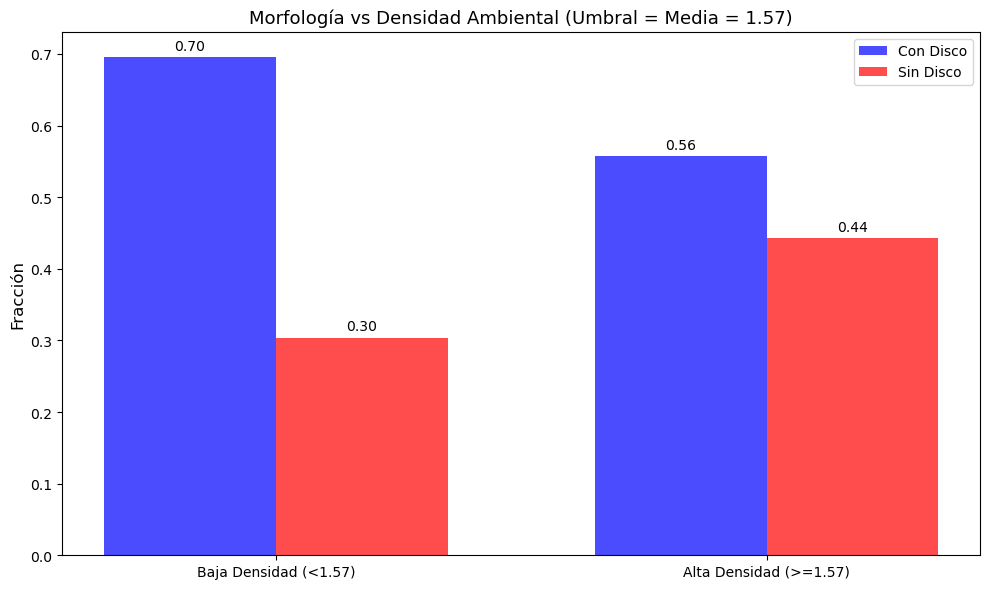



Tabla de contingencia (umbral = media):
                       Con Disco  Sin Disco
Baja Densidad (<1.57):    71         31
Alta Densidad (>=1.57):   34         27


NameError: name 'fisher_exact' is not defined

In [62]:
# Análisis con umbral = media de Mvir/Mdom
# Combinar todas las galaxias para calcular la media
all_mvir_mdom_mean = np.concatenate([mvir_mdom_disk, mvir_mdom_nodisk])
threshold_mean = np.mean(all_mvir_mdom_mean)

print(f"Media de Mvir/Mdom: {threshold_mean:.3f}")

# Galaxias con disco
disk_low_density_mean = mvir_mdom_disk[mvir_mdom_disk < threshold_mean]
disk_high_density_mean = mvir_mdom_disk[mvir_mdom_disk >= threshold_mean]

# Galaxias sin disco
nodisk_low_density_mean = mvir_mdom_nodisk[mvir_mdom_nodisk < threshold_mean]
nodisk_high_density_mean = mvir_mdom_nodisk[mvir_mdom_nodisk >= threshold_mean]

# Conteos
n_disk_low_mean = len(disk_low_density_mean)
n_disk_high_mean = len(disk_high_density_mean)
n_nodisk_low_mean = len(nodisk_low_density_mean)
n_nodisk_high_mean = len(nodisk_high_density_mean)

total_low_mean = n_disk_low_mean + n_nodisk_low_mean
total_high_mean = n_disk_high_mean + n_nodisk_high_mean

# Fracciones
frac_disk_low_mean = n_disk_low_mean / total_low_mean if total_low_mean > 0 else 0
frac_nodisk_low_mean = n_nodisk_low_mean / total_low_mean if total_low_mean > 0 else 0

frac_disk_high_mean = n_disk_high_mean / total_high_mean if total_high_mean > 0 else 0
frac_nodisk_high_mean = n_nodisk_high_mean / total_high_mean if total_high_mean > 0 else 0

print(f"\nBaja Densidad (Mvir/Mdom < {threshold_mean:.3f}):")
print(f"  Total: {total_low_mean}")
print(f"  Con Disco: {n_disk_low_mean} ({frac_disk_low_mean:.2%})")
print(f"  Sin Disco: {n_nodisk_low_mean} ({frac_nodisk_low_mean:.2%})")

print(f"\nAlta Densidad (Mvir/Mdom >= {threshold_mean:.3f}):")
print(f"  Total: {total_high_mean}")
print(f"  Con Disco: {n_disk_high_mean} ({frac_disk_high_mean:.2%})")
print(f"  Sin Disco: {n_nodisk_high_mean} ({frac_nodisk_high_mean:.2%})")

# Gráfico de barras
labels_mean = [f'Baja Densidad (<{threshold_mean:.2f})', f'Alta Densidad (>={threshold_mean:.2f})']
disk_fracs_mean = [frac_disk_low_mean, frac_disk_high_mean]
nodisk_fracs_mean = [frac_nodisk_low_mean, frac_nodisk_high_mean]

x_mean = np.arange(len(labels_mean))
width_mean = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x_mean - width_mean/2, disk_fracs_mean, width_mean, label='Con Disco', color='blue', alpha=0.7)
rects2 = ax.bar(x_mean + width_mean/2, nodisk_fracs_mean, width_mean, label='Sin Disco', color='red', alpha=0.7)

ax.set_ylabel('Fracción', fontsize=12)
ax.set_title(f'Morfología vs Densidad Ambiental (Umbral = Media = {threshold_mean:.2f})', fontsize=13)
ax.set_xticks(x_mean)
ax.set_xticklabels(labels_mean)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()

# Test estadístico
contingency_table_mean = np.array([
    [n_disk_low_mean, n_nodisk_low_mean],      # Baja densidad
    [n_disk_high_mean, n_nodisk_high_mean]     # Alta densidad
])

print("\n" + "="*60)
print("\nTabla de contingencia (umbral = media):")
print("                       Con Disco  Sin Disco")
print(f"Baja Densidad (<{threshold_mean:.2f}):   {n_disk_low_mean:3d}        {n_nodisk_low_mean:3d}")
print(f"Alta Densidad (>={threshold_mean:.2f}):  {n_disk_high_mean:3d}        {n_nodisk_high_mean:3d}")

# Test de Fisher
oddsratio_mean, p_fisher_mean = fisher_exact(contingency_table_mean)
print(f"\nFisher's Exact Test:")
print(f"  Odds Ratio: {oddsratio_mean:.3f}")
print(f"  p-value: {p_fisher_mean:.4f}")

# Chi-cuadrado
chi2_mean, p_chi2_mean, dof_mean, expected_mean = chi2_contingency(contingency_table_mean)
print(f"\nChi-cuadrado Test:")
print(f"  Chi2: {chi2_mean:.3f}")
print(f"  p-value: {p_chi2_mean:.4f}")
print(f"  Grados de libertad: {dof_mean}")

if p_fisher_mean < 0.05:
    print("\n✓ La diferencia ES estadísticamente significativa (p < 0.05)")
else:
    print("\n✗ La diferencia NO es estadísticamente significativa (p >= 0.05)")